# Work in Progress

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import numpy as np
import numpy.linalg as la

from scipy.spatial import cKDTree
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.stats import linregress as linreg

import pandas as pd

import pickle
import os.path

import warnings
warnings.simplefilter('ignore')

#from poly_basis import *

#from ex2_helper import *

from rbf_dict import *

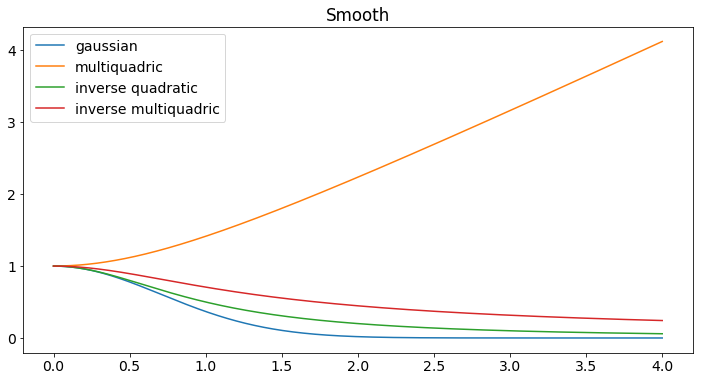

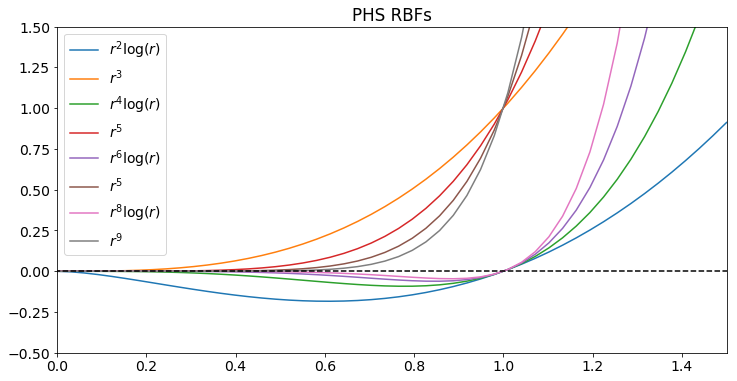

In [8]:

xs = np.linspace(0,4,1000)
eps = 1

fig = plt.figure(figsize=(12,6))
shape_rbfs = [rbf_obj for rbf_obj in rbf_dict.values() if rbf_obj['type']=='shape' ]
legend = []
for rbf_obj in shape_rbfs:
    label = rbf_obj['label']
    rbf = rbf_obj['phi']
    rbf_type = rbf_obj['type']
    tex = rbf_obj['tex']
    legend += [tex]
    plt.plot(xs, rbf(xs, eps))
plt.title('Smooth')
plt.legend(legend)
plt.show()

xs = np.linspace(0,1.5)

fig = plt.figure(figsize=(12,6))
phs_rbfs = [rbf_obj for rbf_obj in rbf_dict.values() if rbf_obj['type']=='phs' ]
legend = []
for rbf_obj in phs_rbfs:
    label = rbf_obj['label']
    rbf = rbf_obj['phi']
    rbf_type = rbf_obj['type']
    tex = rbf_obj['tex']
    legend += [tex]
    plt.plot(xs, rbf(xs, eps))
plt.title('PHS RBFs')
plt.ylim((-.5,1.5))
plt.xlim((0, 1.5))
plt.plot([-2,3], [0,0], 'k--')
plt.legend(legend)
plt.show()

In [10]:
h = .00001
r = .5
eps = 1

for rbf_obj in rbf_dict.values():
    label = rbf_obj['label']
    rbf = rbf_obj['phi']
    rbf_type = rbf_obj['type']
    tex = rbf_obj['tex']
    d_div_r = rbf_obj['zeta']
    #print(label)
    approx = rbf(r+h, eps) - rbf(r-h,eps)
    approx /= 2*h*r
    print('%s: %g' % (label, approx-d_div_r(r,eps)))
    

gaussian: 1.38214e-10
multiquadric: -2.15963e-11
inverse quadratic: 1.07522e-10
inverse multiquadric: 5.05836e-11
log(r)r^2: 1.34861e-10
r^3: 1.98564e-10
log(r)r^4: 1.56692e-10
r^5: 4.99185e-10
log(r)r^6: -3.79825e-11
r^7: 4.37109e-10
log(r)r^8: -9.03672e-11
r^9: 2.62361e-10


In [5]:
from sympy import *

In [6]:
r, eps = symbols('r, eps')

In [7]:
f = 1/sqrt(1+(eps*r)**2)
display(f.diff(r)/r)

-eps**2/(eps**2*r**2 + 1)**(3/2)

# Parameters

In [12]:
file_name = 'node_sets'
notes = ''

node_sets = ['spiral', 'sym_t_design', 'min_energy', 'max_det', 'icos']
#node_sets = ['spiral']

ns = [400 * 2**i for i in range(0,6)]
#ns = [50, 170, 500]


#rbf_labels = ['r^3', 'r^4*log(r)', 'r^5', 'r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9', 'gaussian']
#rbf_labels = ['r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9']
#rbf_labels = ['r^3', 'r^5', 'r^9', 'gaussian']
rbf_labels = ['gaussian']
#rbf_labels = ['r^9', 'gaussian']
#rbf_labels = ['r^9']

#epsilons = [1, .5, .25, .1, .05]
epsilons = [1]
optimize_epsilon = True
target_cond = 10**12
optimize_all_stencils = True

#basis_degs = [4] # -1 for no terms
basis_degs = range(2,5) # -1 for no terms
basis_types = ['s'] * len(basis_degs) # p for polynomial and s for spherical harmonics


'''
solution_index = 20

sol_deg = sphere_harm_degs[solution_index]
foo = lambda x: sphere_harm[solution_index](*x)*sol_deg*(sol_deg+1)
exact = lambda x: sphere_harm[solution_index](*x)
print('Harmonic degree: %d' % sphere_harm_degs[solution_index])
'''

#foo, exact = foo3, exact3

#gaussian foos
sigmas = [2, .5, .3, .1, 5, 2, 1.5]
ys = np.array([ [0,0,1],
                [1,-1,1],
                [2,0,1],
                [-5,7,0],
                [2,-13,1],
                [2,12,-15],
                [1,0,-1]], dtype=np.float)

#project ys onto sphere
for i, y in enumerate(ys):
    ys[i] = 1.0/la.norm(y)* y
foo = lambda x: foo_gauss(x, sigmas, ys)
exact = lambda x: exact_gauss(x, sigmas, ys)


#stencil_sizes = [7, 11, 31]
#stencil_sizes = [11, 23, 31]
stencil_sizes = [13]
auto_choose_stencil = True


calculate_weights_cond = False
calculate_stencil_conds = False







# Validation

assert len(basis_types) == len(basis_degs)
assert len(ys) == len(sigmas)
def choose_stencil_size(deg):
    return max(2*(deg+1)**2, 11)

# Print Profile
print('ns:', ns)

print('%d trials to run' % (len(ns)*len(node_sets)*len(rbf_labels)*len(basis_degs)))

ns: [400, 800, 1600, 3200, 6400, 12800]
90 trials to run


# Run

In [ ]:
columns = ['node_set', 'rbf',  'epsilon', 'basis_deg', 'basis_type', 'N', 'stencil_size', 
           'max_error', 'rel_L2_error']
data = pd.DataFrame(columns=columns)

assert len(basis_types) == len(basis_degs)
for node_set in node_sets:
    #print(node_set + ' nodes')
    for n_try in ns:
        # generate nodes
        if node_set == 'spiral':
            n = n_try
            nodes = gen_spiral_nodes(n)
        elif node_set == 'sym_t_design':
            n, nodes = gen_symmetric_t_design_nodes(n_try)
        elif node_set == 'min_energy':
            n, nodes = gen_min_energy_nodes(n_try)
        elif node_set == 'max_det':
            n, nodes = gen_max_det_nodes(n_try)
        elif node_set == 'icos':
            n, nodes = gen_equ_area_icos_nodes(n_try)
        
        projectors = [np.eye(3) - np.outer(node, node) for node in nodes]
        avg_val = np.sum([exact(node) for node in nodes])
        print('%s nodes, n= %d' % (node_set,n))

        # generate stencils
        tree = cKDTree(np.array(nodes))
        

        # generate weights
        for rbf_label in rbf_labels:
            print('\trbf: ' + rbf_label)
            rbf, d_phi_dr_div_r = rbf_dict[rbf_label]
            skip_no_epsilon = False
            if optimize_epsilon:
                epsilons = [1]
            for epsilon in epsilons:
                eps_fallback = epsilon
                if skip_no_epsilon:
                    continue
                if rbf_label not in shape_rbfs:
                    #epsilon = ''
                    skip_no_epsilon = True
                else:
                    print('\t\tepsilon %f' % epsilon)
                
                for stencil_size in stencil_sizes:
                    if auto_choose_stencil:
                        if stencil_size != stencil_sizes[0]:
                            continue
                            # skip if doing more than one stencil size
                    if stencil_size > n:
                        stencil_size = n
                    
                    stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                    print('\t\t\tstencil size: %d' % stencil_size)
                    
                    for basis_deg, basis_type in zip(basis_degs, basis_types):
                        if calculate_stencil_conds:
                            largest_stencil_cond = 0
                        else:
                            largest_stencil_cond = '-'
                            skeel = '-'
                        if auto_choose_stencil:
                            stencil_size = choose_stencil_size(basis_deg)
                            stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                            
                        if stencil_size > n:
                            stencil_size = n
                            
                        if auto_choose_stencil:
                            print('\t\t\tstencil size changed: %d' % stencil_size)
                        
                        #begin inner loop
                        weights = np.zeros((n, stencil_size))
                        row_index = [r for r in range(n) for c in range(stencil_size)]
                        col_index = np.zeros((n, stencil_size))
                        for i, stencil in enumerate(stencils):

                            col_index[i] = stencil
                            nn = np.array([nodes[i] for i in stencil])
                            nn_proj = np.array([projectors[i] for i in stencil])
                            center_x, center_y, center_z = nn[0]
                            
                            if basis_type == 'p':
                                P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)
                            elif basis_type == 's':
                                P, rhs_x, rhs_y, rhs_z = gen_sphere_harm_basis(basis_deg, nn, nn_proj)
                            
                            if optimize_epsilon and (i==0 or optimize_all_stencils) and not skip_no_epsilon:
                                # optimize cond for first stencil
                                #dist_mat = np.array([[dist(node, node_center) 
                                #        for node in nn] for node_center in nn])
                                dist_mat = dist_outer(nn,nn)
                                
                                optimization_result = minimize_scalar(root_find, args=(dist_mat, P, target_cond))
                                epsilon = optimization_result['x']
                                # test if good
                                A = rbf(dist_outer(nn, nn))
                                num_basis = P.shape[1]
                                AP = np.block([[A,P],[P.T, np.zeros((num_basis,num_basis))]])
                                if cond(AP) > 10**16:
                                    optimization_result = minimize_scalar(root_find, 
                                                  bracket=[np.sqrt(n)/16/2, np.sqrt(n)/16*2],
                                                  args=(dist_mat, P, target_cond))
                                if optimization_result['success']:
                                    epsilon = optimization_result['x']
                                    eps_fallback = eps_fallback
                                else:
                                    epsilon = eps_fallback
                                if i==0:
                                    print(print('\t\tepsilon %f' % epsilon))

                            #A = np.array([[rbf(dist(node, node_center)) for node in nn] for node_center in nn])
                            A = rbf(dist_outer(nn, nn))
                            #P = np.array([[1, x-center_x, y-center_y, z-center_z] for x,y,z in nn])
                            #P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)

                            num_basis = P.shape[1]

                            AP = np.block([[A,P],[P.T, np.zeros((num_basis,num_basis))]])
                            
                            if calculate_stencil_conds:
                                my_cond = cond(AP)
                                if i==0:
                                    skeel = skeel_cond(AP)
                                if my_cond > largest_stencil_cond:
                                    largest_stencil_cond = my_cond

                            #rhsAs = np.array([ [ nn_proj[j]@grad_rbf(node, node_center) 
                            #                    for j, node in enumerate(nn) ]
                            #                    for node_center in nn] )
                            #rhsAs = np.matmul(nn_proj, 
                            #               np.array([[grad_rbf(node, node_center) for node in nn] 
                            #               for node_center in nn]).reshape((50,50,3,1))).reshape((50,50,3))
                            rhsAs = np.matmul(nn_proj, 
                                              grad_rbf_outer(nn, nn).reshape(
                                                (stencil_size,stencil_size,3,1))).reshape(
                                                (stencil_size,stencil_size,3))
                            
                            singular_stencil = False
                            try:
                                rhsA = rhsAs[:,:,0] # only the x coordinates
                                rhs = np.block([[rhsA],
                                                [rhs_x]])
                                weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                                weights[i] = (weights_grad@weights_grad)[0]

                                rhsA = rhsAs[:,:,1] # only the y coordinates
                                rhs = np.block([[rhsA],
                                                [rhs_y]])
                                weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                                weights[i] += (weights_grad@weights_grad)[0]

                                rhsA = rhsAs[:,:,2] # only the z coordinates
                                rhs = np.block([[rhsA],
                                                [rhs_z]])
                                weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                                weights[i] += (weights_grad@weights_grad)[0]
                            except la.LinAlgError:
                                print('Singular stencil, skipping case.')
                                singular_stencil = True

                        if singular_stencil:
                            continue
                        C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

                        # solve steady-state
                        C = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                                        np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')
                        rhs = [-foo(node) for node in nodes] + [avg_val]
                        if calculate_weights_cond:
                            weights_cond = cond(C.todense())
                        else:
                            weights_cond = '-'
                        u = spsolve(C, rhs)
                        u = u[:-1]
                        u_true = np.array([exact(node) for node in nodes])
                        data = data.append( 
                            {'node_set': node_set, 'rbf':rbf_label, 'epsilon': epsilon,
                             'basis_deg':np.int(basis_deg), 'basis_type' : basis_type,
                             'N':n, 'stencil_size':stencil_size,
                             'max_error':np.max( np.abs(u-u_true ) ), 
                             'rel_L2_error':la.norm(u-u_true)/la.norm(u_true),
                             'stencil_cond': largest_stencil_cond, 
                             'skeel_cond' : skeel,
                             'weights_cond': weights_cond,
                             'target_cond' : target_cond}, ignore_index=True)